In [239]:
%reset

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(3198)

def rational_approximation(t):

    # Abramowitz and Stegun formula 26.2.23.
    # The absolute value of the error should be less than 4.5 e-4.
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    numerator = (c[2]*t + c[1])*t + c[0]
    denominator = ((d[2]*t + d[1])*t + d[0])*t + 1.0
    return t - numerator / denominator

def normal_cdf_inverse(p):
    p[p <= 0.5] = -rational_approximation( np.sqrt(-2.0*np.log(p[p <= 0.5])) )
    p[p > 0.5] = rational_approximation( np.sqrt(-2.0*np.log(1.0-p[p > 0.5])) )
    return p

def get_brownian_bridge_indices(max_index):
    bb_indices = np.zeros(max_index + 1, np.int32)
    bb_indices[0] = 0
    bb_indices[1] = max_index
    bb_parents = [None] * (max_index + 1)
    j = 2
    index_pairs = [[0,max_index]]
    continue_flag = True
    while continue_flag:
        continue_flag = False
        i = 0
        index_pairs_new = index_pairs.copy()
        for pair in index_pairs:
            if pair[1] > pair[0] + 1:
                continue_flag = True
                middle = math.ceil((pair[0] + pair[1]) / 2)
                index_pairs_new[i] = [pair[0], middle]                
                index_pairs_new.append([middle, pair[1]])
                bb_indices[j] = middle
                bb_parents[j] = pair
                i += 1
                j += 1
        index_pairs = index_pairs_new        
    return bb_indices, bb_parents

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
# Generate the time vector and standard normals

paths = 10
max_t = 32
t = np.transpose(np.tile(np.arange(0,max_t), (paths, 1)))
t = t/np.max(t)
n = t.shape[0]
m = t.shape[1]
u = np.random.uniform(0,1,(n,m))
z = normal_cdf_inverse(u)

Standard Construction of the Winer process


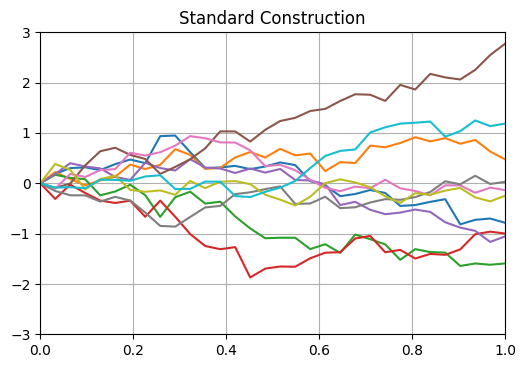

In [276]:
# Standard construction of the Wiener process
i = np.arange(0,n - 1)
dw = z[1:,:] * np.sqrt(t[i+1,:] - t[i,:])
wiener_process_std = np.insert(np.cumsum(dw, axis=0), 0, 0.0, axis=0)

fig = plt.figure(dpi=100)
plt.plot(t, wiener_process_std)
plt.axis([0, np.max(t), -3*np.max(t), 3*np.max(t)])
plt.grid()
plt.title("Standard Construction");

jacobian_mtx_std = np.zeros((n,n))
for i in range(1, n):
  jacobian_mtx_std[i-1:,i] = np.sqrt(t[i,0] - t[i-1,0])

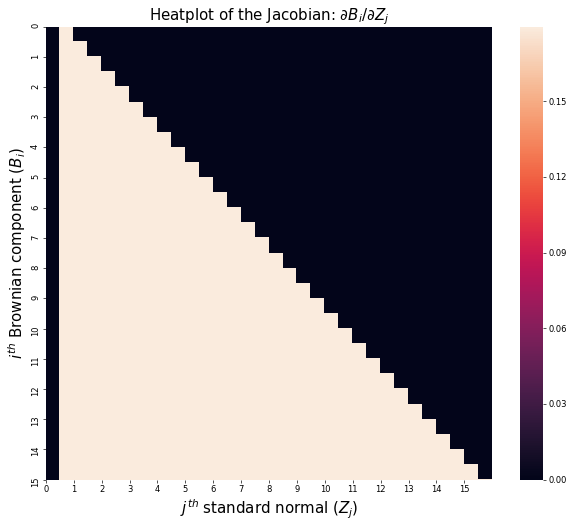

In [277]:
# Display the Jacobian for the standard onstruction of the Winer process, i.e.
# the derivative of W(ti) # with respect to the jth standard normal

jacobian_mtx = jacobian_mtx_std
fig = plt.figure(figsize=(12, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = plt.axes()
# im = ax.imshow(jacobian_mtx)
# plt.pcolor(jacobian_mtx, cmap = 'hot')
ax = sns.heatmap(jacobian_mtx)
ax.set_xticks(np.arange(0, n, 2));
ax.set_yticks(np.arange(0, n, 2));
plt.xlabel('$j^{th}$ standard normal ($Z_j$)', fontsize=18)
plt.ylabel('$i^{th}$ Brownian component ($B_i$)', fontsize=18)
plt.title('Heatplot of the Jacobian: $\partial B_i / \partial Z_j$', fontsize=18);

Brownian Bridge construction of the Winer process


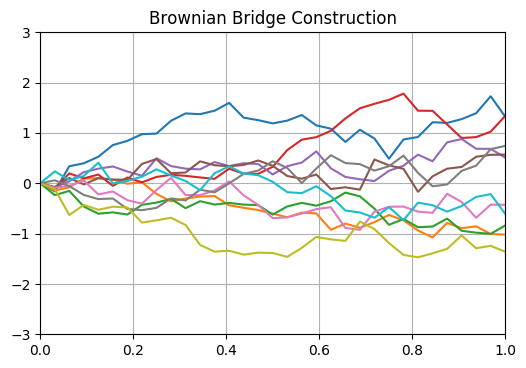

In [243]:
# Brownian Bridge construction of the Wiener process
bb_indices, bb_parents = get_brownian_bridge_indices(n - 1)

wiener_process_bb = np.zeros((n,m))
wiener_process_bb[0,:] = 0.0
wiener_process_bb[n-1,:] = np.sqrt(t[n-1] - t[0]) * z[1]
jacobian_mtx_bb = np.zeros((n,n,m))
jacobian_mtx_bb[n-1,1,:] = np.sqrt(t[n-1] - t[0])
for i in range(2, n):
    # indices of current step and its parents
    bi = bb_indices[i]
    p0 = bb_parents[i][0]
    p1 = bb_parents[i][1]
    
    # time coordinates of current step and its parents
    si = t[p0]
    ui = t[p1]
    ti = t[bi]
    
    # values of the parents of the Wiener process at ti
    ws = wiener_process_bb[p0]
    wu = wiener_process_bb[p1]
        
    zi = z[i]
    cs = (ui - ti)/(ui - si)
    cu = (ti - si)/(ui - si)
    cz = np.sqrt(cs*cu*(ui - si))
    
    # Brownian bridge calculation
    wiener_process_bb[bi] = cs*ws + cu*wu + cz*zi
    
    # sensitivity of Wiener process at ti to all the normals
    jacobian_mtx_bb[bi] = jacobian_mtx_bb[p0]*cs + jacobian_mtx_bb[p1]*cu
    jacobian_mtx_bb[bi,i] += cz
    
fig = plt.figure(dpi = 100)
plt.axis([0, np.max(t), -3*np.max(t), 3*np.max(t)])
plt.plot(t, wiener_process_bb)
plt.grid()
plt.title("Brownian Bridge Construction");

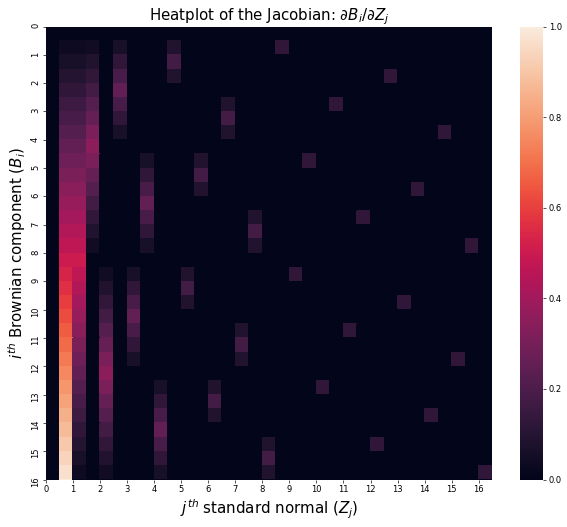

In [251]:
# Display the Jacobian for the Brownian bridge construction of the Winer process,
# i.e. the derivative of W(ti) # with respect to the jth standard normal

jacobian_mtx = jacobian_mtx_bb[:,:,0]
fig = plt.figure(figsize=(12, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = plt.axes()
# im = ax.imshow(jacobian_mtx)
# plt.pcolor(jacobian_mtx, cmap = 'hot')
ax = sns.heatmap(jacobian_mtx)
ax.set_xticks(np.arange(0, n, 2));
ax.set_yticks(np.arange(0, n, 2));
plt.xlabel('$j^{th}$ standard normal ($Z_j$)', fontsize=18)
plt.ylabel('$i^{th}$ Brownian component ($B_i$)', fontsize=18)
plt.title('Heatplot of the Jacobian: $\partial B_i / \partial Z_j$', fontsize=18);

### Total Sensitivity:

Let $t = t_0, t_1, \ldots, t_n$ and $W_i$ be the Winer process at $t = t_i$ for $i = 0, 1, \ldots, n$. Then the following condition holds:

\begin{equation}
\frac{\partial W_i}{\partial \mathbf{z}} \cdot \frac{\partial W_i}{\partial \mathbf{z}} = t_i - t_0,
\end{equation}

where $\mathbf{z} = [z_0, z_1, \ldots, z_n]$ is the vector of standard normals used in the construction of the Wiener process.

In [0]:
assert (np.abs(np.sum(jacobian_mtx * jacobian_mtx, axis=1) - (t - t[0])) < 1e-14).all(), "The statement is not true!"

 Principal component construction of the Wiener process




99% of the variance is explained by the first 15 principal components.


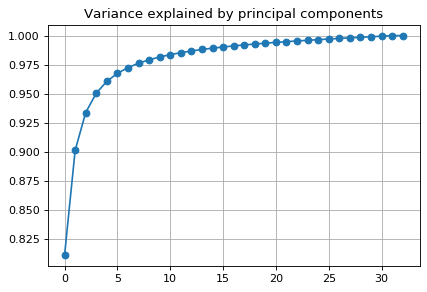

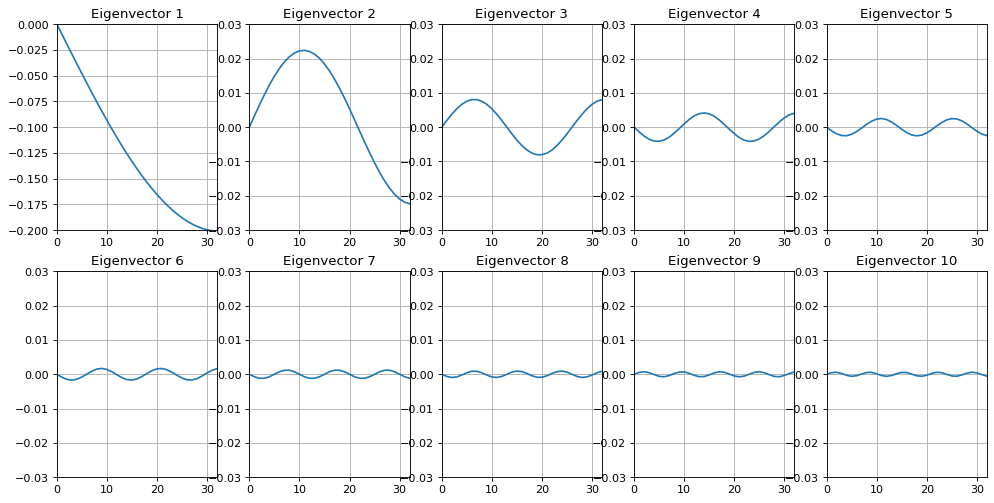

In [252]:
# Principal component construction of the Wiener process

# Calculate the covariance matrix
covariance_mtx = np.zeros((n, n))
for i in range(0, n):
  for j in range(0, n):
    covariance_mtx[i, j] = min(t[i,0], t[j,0])

# Calculate eigendecomposition of the covariance matrix C and ensure that V*D*Vt = C
eig_vals, eig_vecs = np.linalg.eig(covariance_mtx)
assert (np.abs(np.matmul(np.matmul(eig_vecs, np.diag(eig_vals)), np.transpose(eig_vecs)) - covariance_mtx)).all() < 1e-14, "Invalid eigendecomposition."

# Variance explained by the principal components
cutoff_value = 0.99
explained_variance = np.cumsum(eig_vals)/np.sum(eig_vals)
cutoff_index = np.where(explained_variance > cutoff_value)[0][0]
print("%d%% of the variance is explained by the first %d principal components." % (cutoff_value * 100, cutoff_index))

fig = plt.figure(dpi=80)
plt.plot(explained_variance, '-o'), plt.grid(), plt.title("Variance explained by principal components")

# Plot the eigenvectors
fig = plt.figure(figsize=(15, 7.5), dpi= 80, facecolor='w', edgecolor='k')

for i in range(0, 10):
  plt.subplot(2,5,i+1), plt.plot(eig_vecs[:,i] * eig_vals[i]/np.sum(eig_vals)), plt.grid(), plt.title("Eigenvector " + str(i+1))
  if i == 0:
    plt.axis([0, n-1, -0.2, 0])
  else:
    plt.axis([0, n-1, -0.03, 0.03])

Comparing full vs lower-dimesional approximation to the Wiener process using PCA.


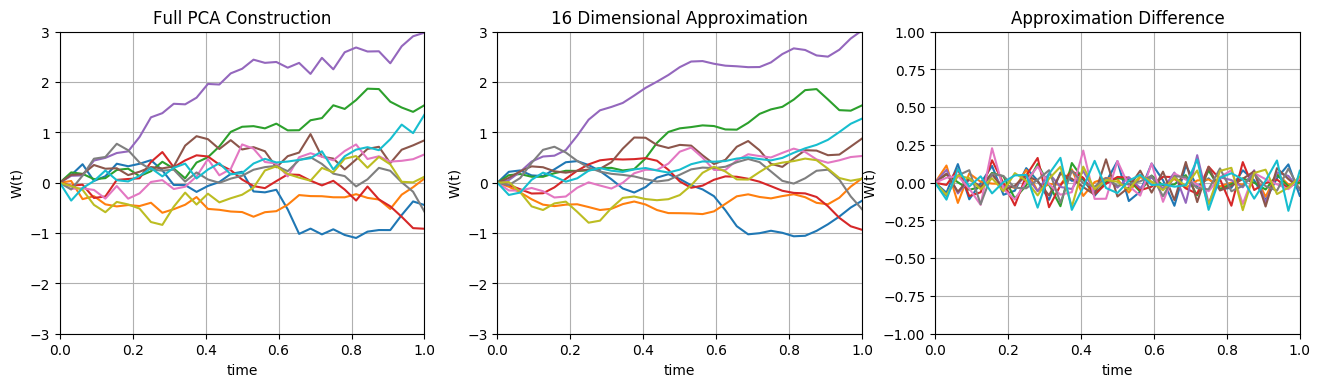

In [253]:
# Construct the Winer process using full and lower-dimensional projections
factor_loading_mtx = np.matmul(eig_vecs, np.diag(np.sqrt(eig_vals)))
wiener_process_pca_full = np.matmul(factor_loading_mtx, z)

factor_loading_mtx_approx = np.matmul(eig_vecs[:,:cutoff_index], np.diag(np.sqrt(eig_vals[:cutoff_index])))
wiener_process_pca_approx = np.matmul(factor_loading_mtx_approx, z[:cutoff_index])

wiener_process_pca_diff = wiener_process_pca_full - wiener_process_pca_approx

fig = plt.figure(figsize=(16,4), dpi = 100)

plt.subplot(1,3,1), plt.xlabel('time'), plt.ylabel("W(t)")
plt.plot(t, wiener_process_pca_full)
plt.axis([0, np.max(t), -3*np.max(t), 3*np.max(t)])
plt.grid(), plt.title("Full PCA Construction")

plt.subplot(1,3,2), plt.xlabel('time'), plt.ylabel("W(t)")
plt.plot(t, wiener_process_pca_approx)
plt.axis([0, np.max(t), -3*np.max(t), 3*np.max(t)])
plt.grid(), plt.title(str(cutoff_index + 1) + " Dimensional Approximation")

plt.subplot(1,3,3), plt.xlabel('time'), plt.ylabel("W(t)")
plt.plot(t, wiener_process_pca_diff)
plt.axis([0, np.max(t), -1, 1])
plt.grid(), plt.title("Approximation Difference")

print("Comparing full vs lower-dimesional approximation to the Wiener process using PCA.")

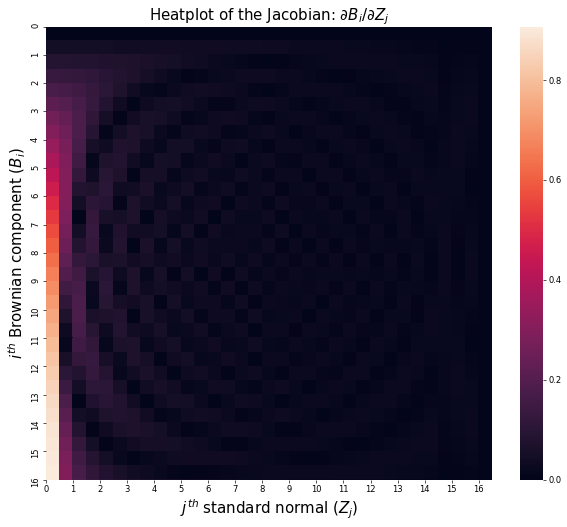

In [262]:
# Display the Jacobian for the principal component construction of the Winer process
# i.e. the derivative of W(ti) # with respect to the jth standard normal

jacobian_mtx = np.abs(factor_loading_mtx)
path = 0
fig = plt.figure(figsize=(12, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = plt.axes()
ax = sns.heatmap(jacobian_mtx)
ax.set_xticks(np.arange(0, n, 2));
ax.set_yticks(np.arange(0, n, 2));
plt.xlabel('$j^{th}$ standard normal ($Z_j$)', fontsize=18)
plt.ylabel('$i^{th}$ Brownian component ($B_i$)', fontsize=18)
plt.title('Heatplot of the Jacobian: $\partial B_i / \partial Z_j$', fontsize=18);